# Harris Corner Detection Demo
> A little demonstration of Harris corner detection process.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [jupyter, harris corner detection, python, computer vision]
- hide: false
- search_exclude: false

## Brief Introduction
Harris corner detection is a classic algorithm in the field of computer vision. It is composed of several steps as below:
1. We convolve the image with Gaussian kernel to denoise the image for further operation.
2. Estimate intensity gradient for each pixel in two perpendicular directions by sobel operators.
3. Calculate local structure for each pixel, and evaluate Harris response based on that.
4. Use non-maximal suppression technique to find the best candidates.


In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imageshow(img, cmap='bgr', savefile=False, filename='output'):
    """ 
    Print image or Save it.

    img: Image to show or to save.
    cmap: Color map of img. Default to 'bgr'
    savefile: To save image or not. Default to 'False'.
    filename: The filename you want the output image has.
              Default to 'output.jpg'
    """
    cwd = os.getcwd() + '/'
    des = cwd + filename + '.jpg'

    if savefile:
        cv2.imwrite(des, img)
    else:
        plt.figure(figsize=(16,16))
        if(cmap == 'bgr'):
            # OpenCV considers float only when values range
            # from 0-1.
            img = img.astype('uint8')
            # Change order from bgr to rgb for plt to show
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=cmap)
        plt.title(filename)
        plt.show()

## Load Image
Image used in this demonstration is credited to [Linda 零打](https://www.instagram.com/lindawuss/), and the image source is [here](https://www.instagram.com/p/BlPyitFgYSN/)!

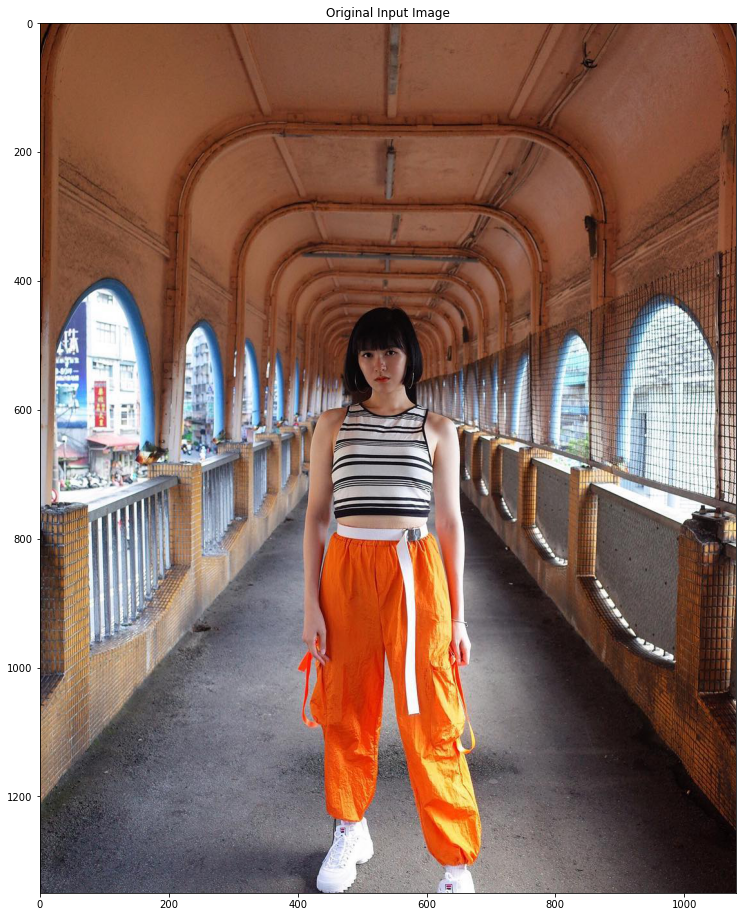

In [3]:
cwd = os.getcwd() + '/'
image_name = 'test.jpg'
image_path = cwd + image_name

# Import the image.
img = cv2.imread(image_path)
imageshow(img, filename='Original Input Image')

## Rotation and Scaling
The `Rotate` and `Scale` functions are used to see if the Harris corner detection is rotation and scaling invariant or not.

In [4]:
def Rotate(img, angle=30):
    """
    Rotate the image by given degree.

    img: The image you want to rotate.
    angle: Degree you want the image to be rotated.
           Default to '30'.
"""

    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rotate_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    img = cv2.warpAffine(img, rotate_matrix,
                         img.shape[1::-1], flags=cv2.INTER_LINEAR)

    print("Done rotation...")

    return img

def Scale(img, scale=0.5):
    """
    Scale the image by given times.

    img: The image you want to scale.
    scale: By how many times you want the image to be scaled.
    """

    y = img.shape[0]
    x = img.shape[1]

    y_start = int(y/2)
    x_start = int(x/2)

    img = cv2.resize(img, (0,0), fx=scale, fy=scale)

    if(scale > 1):
        img = img[y_start:y_start+y, x_start:x_start+x]

    print("Done scaling...")

    return img

In [5]:
### Final part ###

## Rotate the image by 30 degree
# (Uncomment codes below to do rotation)
# img = Rotate(img, angle=30)

## Scale the image by 0.5x
# (Uncomment codes below to do scaling)
# img = Scale(img, scale=0.5)

### End of final part ###

## Step 1. Gaussian Filtering
We convolve the input image with Gaussian kernel to smoothen the image. Before we do the convolution, we have to add padding to handle the border of the image.

### Add Padding to Images
The following picture shows some common padding strategies.
![](https://raw.githubusercontent.com/pjreddie/vision-hw0/master/figs/pad.png "Different Padding Strategies. Image credit to github account [pjreddie](https://github.com/pjreddie/vision-hw0)")
The padding strategy used here is `clamp`.

In [6]:
def GetExtendImage(img, kernel_size=3, show_results=True):
    """
    Get image having 3 channel with half of kernel_size as padding.

    img: Image with **3 channel** to extend.
    kernel_size: Decide how many pixel to extend as padding.
                 Default to 3.
    """
    # Get input image size
    y = img.shape[0]
    x = img.shape[1]

    # Get half of the kernel, which means the
    # pixel number to extend.
    half = int(kernel_size/2)

    # Initialize tmp array
    tmp_len_x = x+2*half
    tmp_len_y = y+2*half
    tmp = np.zeros((tmp_len_y, tmp_len_x, 3))

    # Extending along x axis of original pic
    i_end = tmp_len_y-half-1
    for i in range(tmp_len_y):
        i_half = i-half
        if i_half < 0:
            pass
        elif i > i_end:
            pass
        else:
            for itr in range(tmp_len_x):
                itr_half = itr-half
                if itr_half < 0:
                    tmp[i][itr][0] = img[i_half][0][0]
                    tmp[i][itr][1] = img[i_half][0][1]
                    tmp[i][itr][2] = img[i_half][0][2]
                elif itr > tmp_len_x-half-1:
                    tmp[i][itr][0] = img[i_half][-1][0]
                    tmp[i][itr][1] = img[i_half][-1][1]
                    tmp[i][itr][2] = img[i_half][-1][2]
                else:
                    tmp[i][itr][0] = img[i_half][itr_half][0]
                    tmp[i][itr][1] = img[i_half][itr_half][1]
                    tmp[i][itr][2] = img[i_half][itr_half][2]

    # Transpose both image on dimension 1 and 2 for simplicity
    tmp = np.transpose(tmp, (1, 0, 2))
    img = np.transpose(img, (1, 0, 2))

    # Extending along y axis of original pic
    for i in range(tmp_len_x):
        i_half = i-half
        for itr in range(tmp_len_y):
            itr_half = itr-half
            tmp_len_y_half1 = tmp_len_y-half-1
            if i_half < 0:
                if itr_half < 0:
                    tmp[i][itr][0] = tmp[i][half][0]
                    tmp[i][itr][1] = tmp[i][half][1]
                    tmp[i][itr][2] = tmp[i][half][2]
                elif itr > tmp_len_y_half1:
                    tmp[i][itr][0] = tmp[i][tmp_len_y_half1][0]
                    tmp[i][itr][1] = tmp[i][tmp_len_y_half1][1]
                    tmp[i][itr][2] = tmp[i][tmp_len_y_half1][2]
                else:
                    pass
            elif i > tmp_len_x-half-1:
                if itr_half < 0:
                    tmp[i][itr][0] = tmp[i][half][0]
                    tmp[i][itr][1] = tmp[i][half][1]
                    tmp[i][itr][2] = tmp[i][half][2]
                elif itr > tmp_len_y_half1:
                    tmp[i][itr][0] = tmp[i][tmp_len_y_half1][0]
                    tmp[i][itr][1] = tmp[i][tmp_len_y_half1][1]
                    tmp[i][itr][2] = tmp[i][tmp_len_y_half1][2]
                else:
                    pass
            else:
                if itr_half < 0:
                    tmp[i][itr][0] = img[i_half][0][0]
                    tmp[i][itr][1] = img[i_half][0][1]
                    tmp[i][itr][2] = img[i_half][0][2]
                elif itr > tmp_len_y-half-1:
                    tmp[i][itr][0] = img[i_half][-1][0]
                    tmp[i][itr][1] = img[i_half][-1][1]
                    tmp[i][itr][2] = img[i_half][-1][2]
                else:
                    tmp[i][itr][0] = img[i_half][itr_half][0]
                    tmp[i][itr][1] = img[i_half][itr_half][1]
                    tmp[i][itr][2] = img[i_half][itr_half][2]

    # Back to original
    tmp = np.transpose(tmp, (1, 0, 2))

    # Display the result
    if show_results:
        imageshow(tmp, savefile=False, filename='Image with Padding')

    print("Done extension...")
    return tmp
    ### End of extending the image. ###

### Convolve with Gaussian
After we add padding to the input image, we apply 1D Gaussian kernel below on $x$-axis then on $y$-axis to get the effect of 2D Gaussian filtering to smoothen the input image for further process.
$$G(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{(-\frac{x^2}{2\sigma^2})}$$

In [7]:
def gaussian_smooth(img, sigma=5, kernel_size=10):
    '''
    Return image with Gaussian smoothing.

    img: Image with **3 channels**.
    sigma: Sigma value to do Gaussian smoothing.
           Default to 5.
    kernel_size: Kernel size to do Gaussian smoothing.
                 Default to 10.
    '''

    ### Calculating the Gaussian kernel.###
    # Get the half point of kernel, N
    half = int(kernel_size/2)

    # Initialize kernel
    kernel = []
    for i in range(2*half+1):
        kernel.append(i)
    kernel = np.array(kernel, dtype='float')

    # Initialize the central element
    kernel[half] = 1.

    # Calculate G"_n
    for i in range(1, half+1):
        x_n = 3. * i / half
        kernel[half - i] = kernel[half + i] = ( (1/(sigma * np.sqrt(2.*np.pi)))
                                               * np.exp(-(i**2)/(2.*(sigma**2))) )

    # Calculate k'
    k = sum(kernel)

    # G'_n = G"_n / k'
    kernel /= k

    print('Gaussian kernel:\n', kernel)
    ### End of calculating the Gaussian kernel.###


    ### Extending the image for later sliding. ###
    tmp = GetExtendImage(img, kernel_size=kernel_size)
    tmp_len_x = tmp.shape[1]
    tmp_len_y = tmp.shape[0]
    ### End of extending the image. ###


    ### Comvolving with the kernel. ###
    # Get image size
    y = img.shape[0]
    x = img.shape[1]

    # Reshape array: [H, W, Channel] to [Channel, H, W]
    tmp = np.transpose(tmp, (2, 0, 1))
    img = np.transpose(img, (2, 0, 1))

    # Convolving along x axis
    for i in range(tmp_len_y):
        for j in range(x):
            j_end = j+2*half+1
            tmp[0][i][j] = np.dot(tmp[0][i][j:j_end], kernel)
            tmp[1][i][j] = np.dot(tmp[1][i][j:j_end], kernel)
            tmp[2][i][j] = np.dot(tmp[2][i][j:j_end], kernel)

    # Transpose to apply kernel along y axis
    tmp = np.transpose(tmp, (0, 2, 1))

    # Transpose img to align to tmp
    img = np.transpose(img, (0, 2, 1))

    # Convolving along y axis
    i_end = tmp_len_x-2*half
    for i in range(0, i_end):
        for j in range(y):
            j_end = j+2*half+1
            img[0][i][j] = np.dot(tmp[0][i][j:j_end], kernel)
            img[1][i][j] = np.dot(tmp[1][i][j:j_end], kernel)
            img[2][i][j] = np.dot(tmp[2][i][j:j_end], kernel)

    tmp = np.transpose(tmp, (1, 2, 0))
    img = np.transpose(img, (1, 2, 0))

    # !!!Code below would yield wrong output.
    # The output image would have extended pixel at the right side.
    # Unlike what I thought, which is righthand side of the original
    # image would be on the top of the transposed image.
    #
    # for i in range(2*half+1, tmp_len_x):
    #     for j in range(y):
    #         img[i-2*half-1][j] = np.dot(tmp[i][j:j+2*half+1], kernel)

    # Transpose back to normal
    img = np.transpose(img, (1, 0, 2))

    ###End of convolving with the kernel. ###

    # Display the result
    imageshow(img, savefile=False,
              filename='Image Applied with Gaussian (kernel size '+str(kernel_size)+')')

    print("Done Gaussian...")
    return img

Gaussian kernel:
 [0.02933548 0.03512094 0.0403987  0.04464747 0.04740831 0.60617821
 0.04740831 0.04464747 0.0403987  0.03512094 0.02933548]


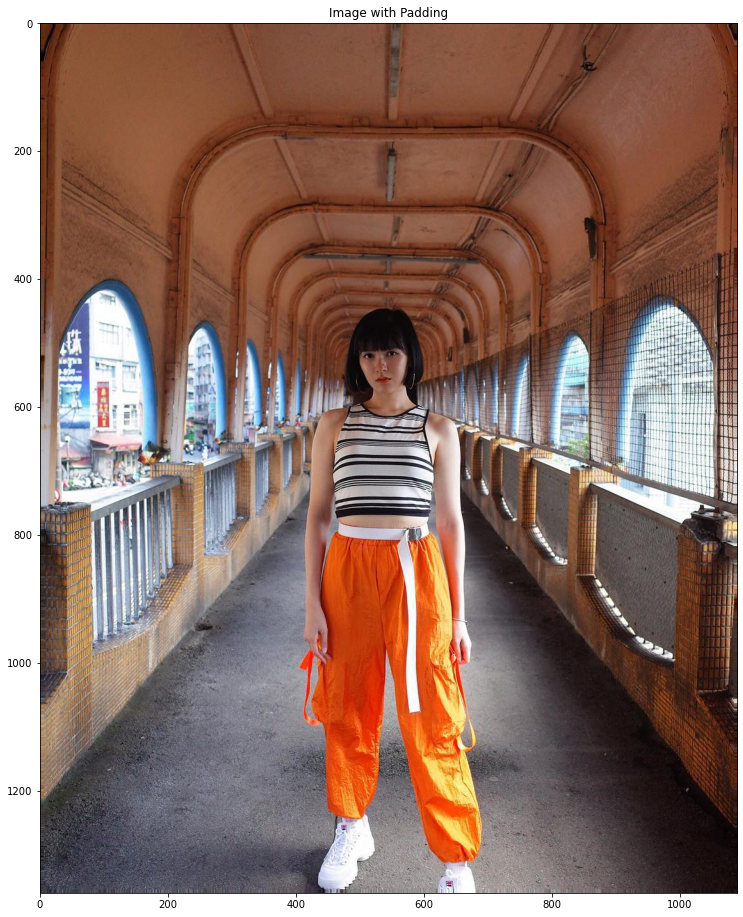

Done extension...


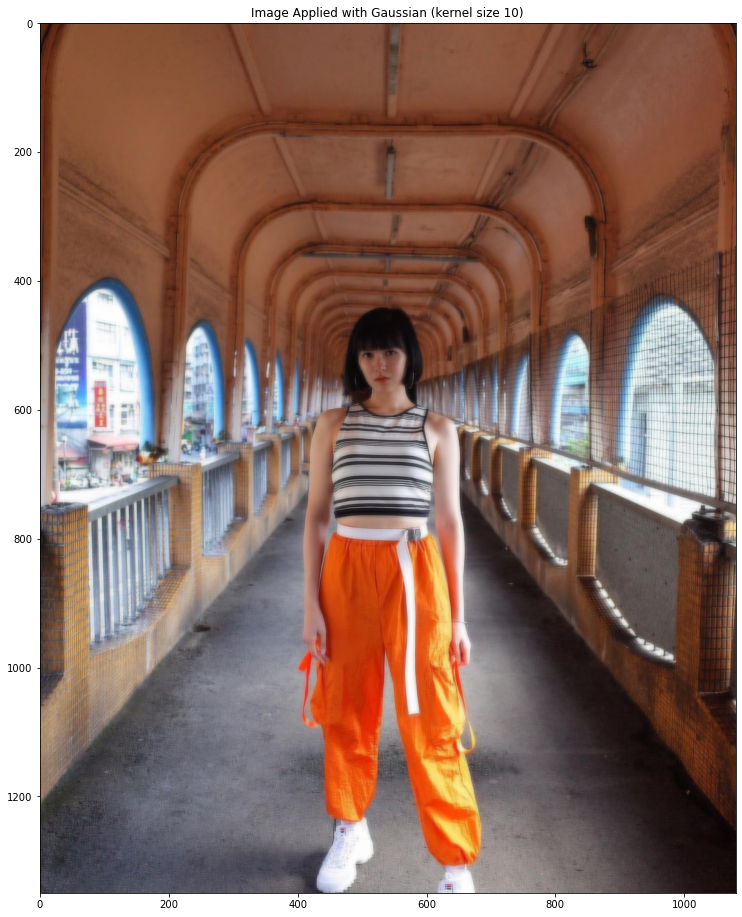

Done Gaussian...


In [8]:
# Do Gaussian smooth
img_gaussian = gaussian_smooth(img, kernel_size=10)

From the `Image with Padding` image, we can see the effect of `clamp` padding strategy around the shoes.

## Step 2. Compute Magnitude and Direction of Gradient by Sobel Operators
Sobel operators are commonly used for approximations of image derivatives.

$$H_x = \frac{1}{8}\begin{bmatrix}-1&0&1\\ -2&0&2\\ -1&0&1\\ \end{bmatrix},\, H_y = \frac{1}{8}\begin{bmatrix}1&2&1\\ 0&0&0\\ -1&-2&-1\\ \end{bmatrix}$$

The $\frac{1}{8}$ term is omitted in the standard definition of the Sobel operators, and it will not affect the edge detection effect. But the $\frac{1}{8}$ term is needed for correct gradient value calculation.

We convolve the blurred image with Sobel operators to get the image derivatives along $x$ and $y$-axis as $I_x$ and $I_y$.

$$I_x = I \star H_x, \, I_y = I \star H_y$$
$I$: blurred image, $\star$: convolution operation

We also calculate the magnitude and direction of the image gradient.

$magnitude = \sqrt{I_x^2 + I_y^2}$

We use `arctan()` for gradient angle estimation.

$\theta = \arctan(\frac{I_y}{I_x})$

$\begin{aligned}  &\theta > 45^{\circ} \to \text{Red}\\
                0^{\circ} \leq \; &\theta \leq 45^{\circ} \to \text{Yellow}\\
                -45^{\circ} \leq \; &\theta \lt 0^{\circ} \to \text{Green}\\
                -45^{\circ} \gt \; &\theta \to \text{Cyan}\\
 \end{aligned}$

In [9]:
def sobel_edge_detection(img):
    '''
    Detect edge of the image, and return image derivatives along x
    and y axis.

    img: Image with **3 channels**.
    '''

    # Set the threshold, '70' based on wiki
    threshold = 100

    # Get image size
    y = img.shape[0]
    x = img.shape[1]

    # For magnitude map
    Mag_map = np.zeros((y, x))

    # For direction map, which is colorized
    Dir_map = np.zeros((y, x, 3))

    # For Image derivatives along x and y
    Ix = np.zeros((y, x))
    Iy = np.zeros((y, x))

    # Define Sobel operator
    Gx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

    Gy = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])

    # Define direction color
    Red = np.array([0,0,255])
    Yellow = np.array([0,255,255])
    Green = np.array([0,255,0])
    Cyan = np.array([255,255,0])


    ### Extending the image for later sliding. ###
    tmp = GetExtendImage(img, kernel_size=3)
    tmp_len_x = tmp.shape[1]
    tmp_len_y = tmp.shape[0]
    ### End of extending the image. ###

    # From BGR to Gray
    tmp = tmp.astype('uint8')
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)

    ### Convolving with the kernel. ###
    for i in range(tmp_len_y-2):
        i_end = i+3
        for j in range(tmp_len_x-2):
            j_end = j+3
            Ix[i][j] = np.sum(np.sum(tmp[i:i_end, j:j_end] * Gx))
            Iy[i][j] = np.sum(np.sum(tmp[i:i_end, j:j_end] * Gy))

            ## Calculating Gradient Magnitude
            # G = sqrt(Gx**2 + Gy**2)
            gradient_mag = np.sqrt(Ix[i][j]**2 + Iy[i][j]**2)

            # max(Mag_map, threshold)
            if (gradient_mag > threshold):
                Mag_map[i][j] = gradient_mag


                ## Calculating Gradient Direction
                # Only apply on 'detected edges'
                # Theta = arctan(Gy/Gx)
                angle = np.arctan( Iy[i][j] / Ix[i][j] )

                # arctan(1) ~ 0.79
                if(angle > 0.79):
                    Dir_map[i][j] = Red
                elif(angle >= 0 and angle <= 0.79):
                    Dir_map[i][j] = Yellow
                elif(angle >=-0.79 and angle < 0):
                    Dir_map[i][j] = Green
                elif(angle < -0.79):
                    Dir_map[i][j] = Cyan
                ## End of Calculating Gradient Direction

            else:
                Mag_map[i][j] = 0

            ## End of Calculating Gradient Magnitude
    ### End of Convolving with the kernel. ###

    # Display the result
#     imageshow(Ix, cmap='gray', savefile=False, filename='sobel_Ix_kernel_10.jpg')
#     imageshow(Iy, cmap='gray', savefile=False, filename='sobel_Iy_kernel_10.jpg')
#     imageshow(Mag_map, cmap='gray', savefile=False, filename='sobel_mag_kernel_10.jpg')
#     imageshow(Dir_map, savefile=False, filename='sobel_dir_kernel_10.jpg')
    imageshow(Ix, cmap='gray', savefile=False, filename='Image Derivatives along x axis (Ix)')
    imageshow(Iy, cmap='gray', savefile=False, filename='Image Derivatives along y axis (Iy)')
    imageshow(Mag_map, cmap='gray', savefile=False, filename='Magnitude of Image Gradient')
    imageshow(Dir_map, savefile=False, filename='Direction of Image Gradient')

    print("Done sobel...")
    return Ix, Iy

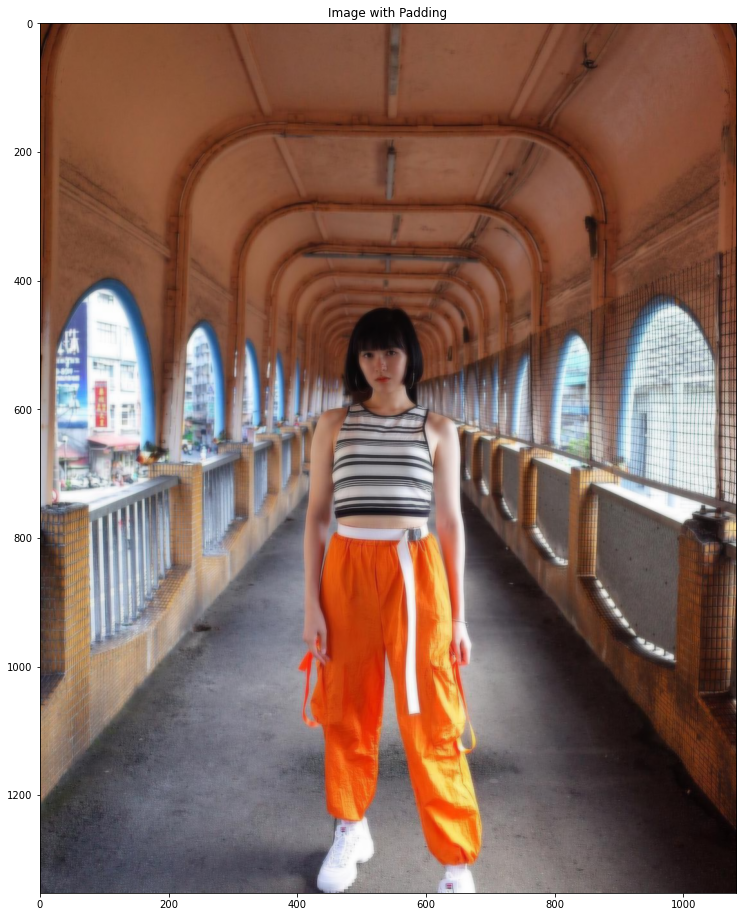

Done extension...


/opt/miniconda3/envs/pRH/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


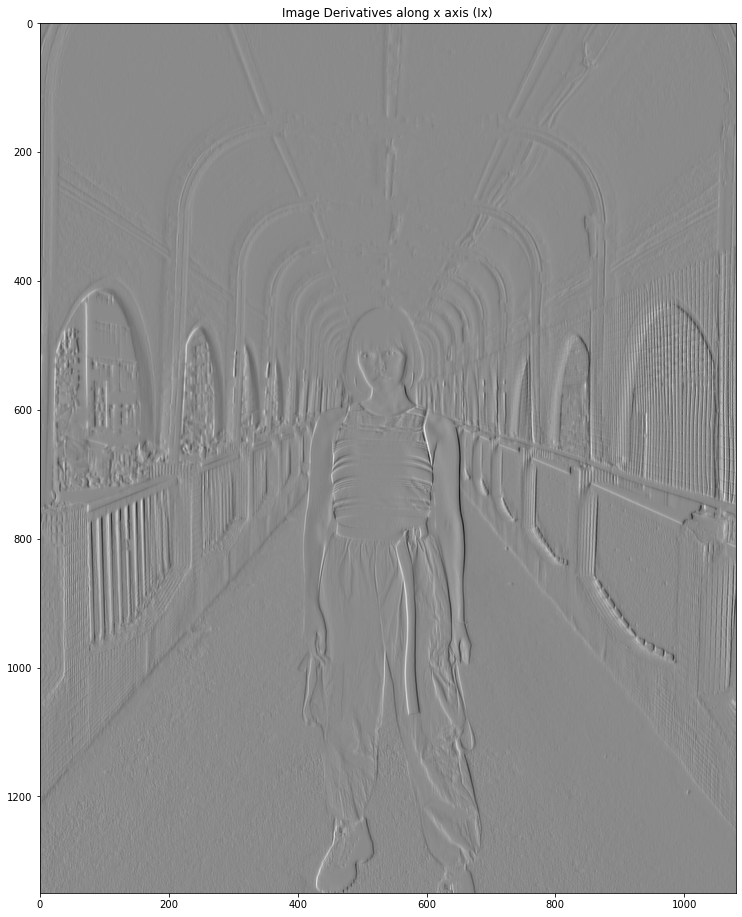

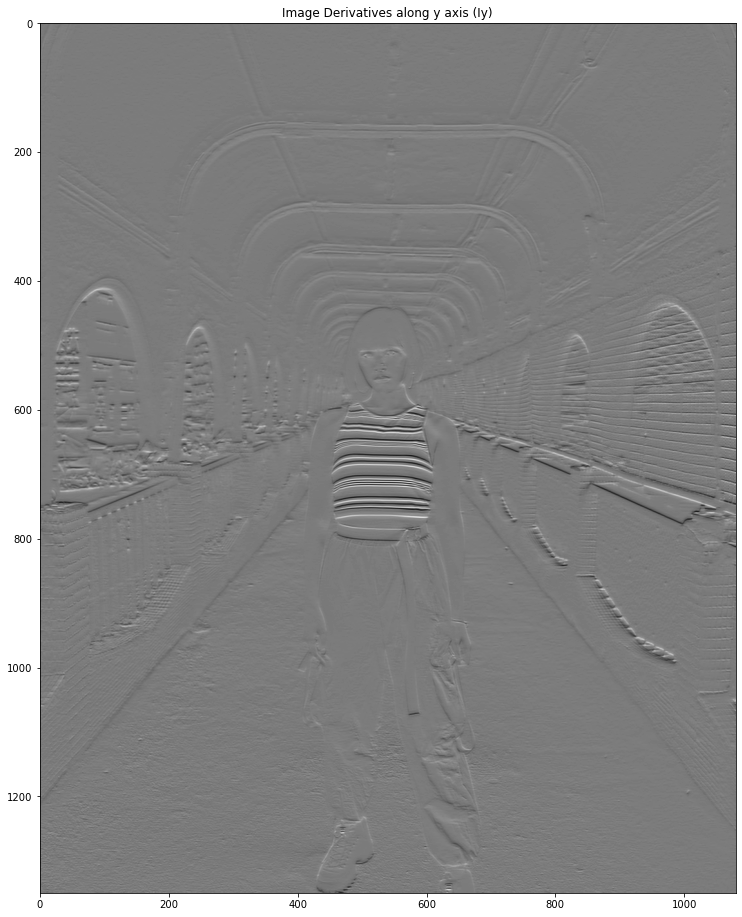

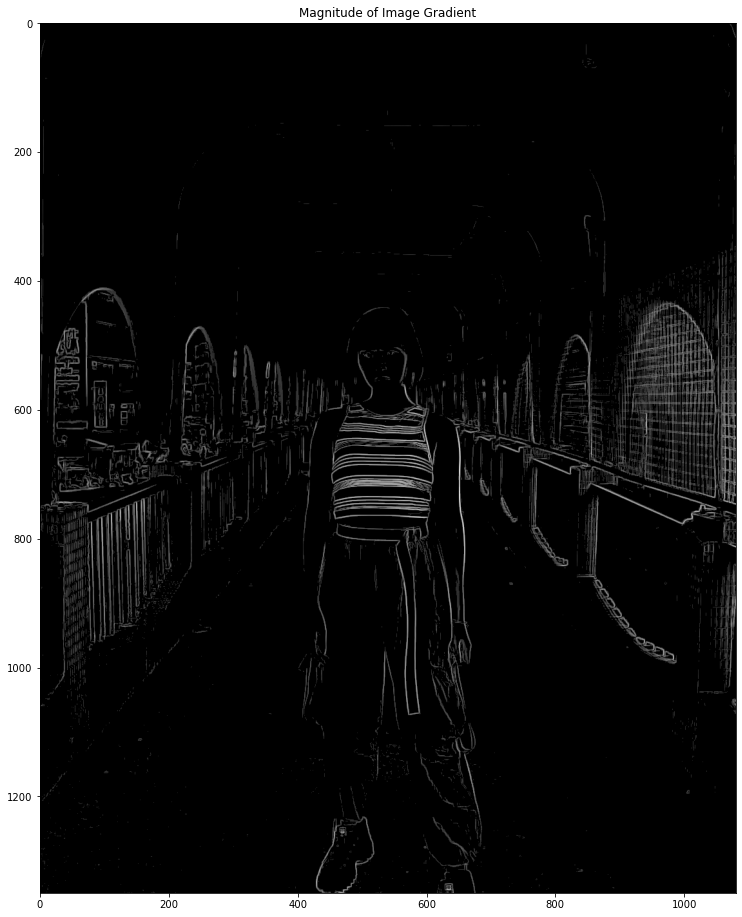

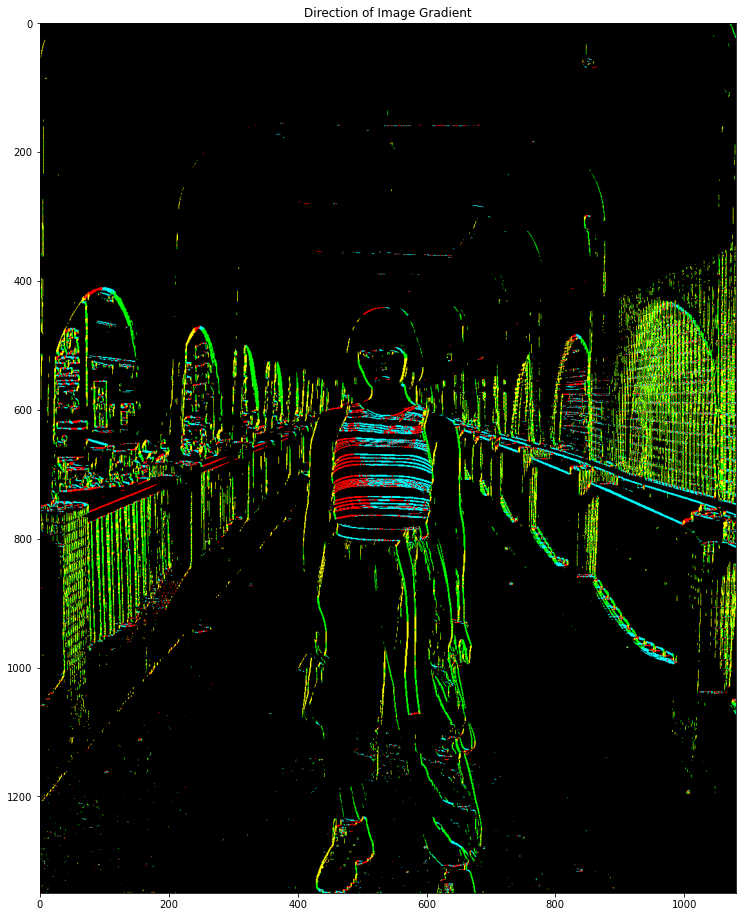

Done sobel...


In [10]:
# Do Sobel Edge Detection and get gradient magnitude
Ix, Iy = sobel_edge_detection(img_gaussian)

$\begin{aligned}  &\theta > 45^{\circ} \to \text{Red}\\
                0^{\circ} \leq \; &\theta \leq 45^{\circ} \to \text{Yellow}\\
                -45^{\circ} \leq \; &\theta \lt 0^{\circ} \to \text{Green}\\
                -45^{\circ} \gt \; &\theta \to \text{Cyan}\\
 \end{aligned}$

### Prepare Gray Scale Image for Marking Corners

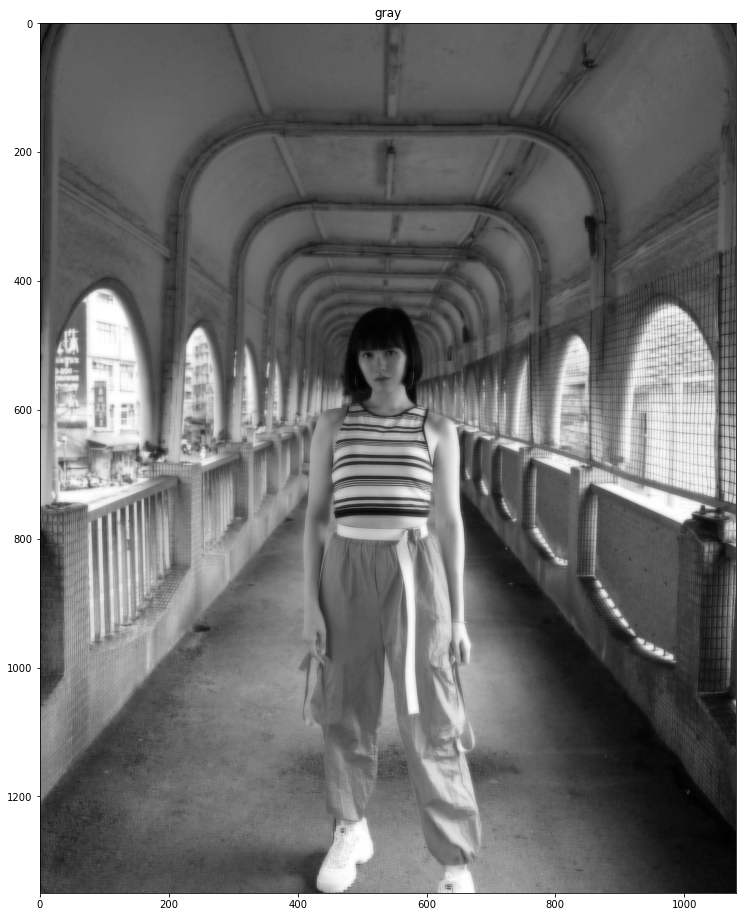

In [11]:
# From BGR to Grayscale
img_gray = img_gaussian.astype('uint8')
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)

imageshow(img_gray, cmap='gray', filename='gray')

### Pack Image Derivatives and Gray Scale Image Together

In [12]:
# Put Ix, Iy, img_gray into img_mix to go further extension.
# (3, H, W) to (H, W, 3)
img_mix = np.array([Ix, Iy, img_gray])
img_mix = np.transpose(img_mix, (1, 2, 0))

## Step 3. Local Structure and Harris Response Calculation
### Local Structure Tensor
We can observe a sliding window to see if there is any change along any direction to guess the region.
* Flat region: no change in all directions
* Edge: no change along the edge direction
* Corner: change in all directions

We calculate summed squared differences(SSD) of every pixel in the window to speculate the motion along $x,y$ direction.

$$E(u,v) = \sum_{(u,v) \in W} [I(x+u, y+v) - I(x,y)]^2$$
* We use $(u,v)$, the shifting along $x,y$-axis respectively, as the index of SSD

According to Taylor series expansion, if the motion $(u,v)$ is small,
$$\begin{aligned} I(x+u, y+v) &\approx I(x,y) + \frac{\partial I}{\partial x}u + \frac{\partial I}{\partial y}v\\
                              &\approx I(x,y) + [I_x, I_y]\,\begin{bmatrix} u\\ v\\ \end{bmatrix} \end{aligned}$$
* $[I_x, I_y]\,\begin{bmatrix} u\\ v\\ \end{bmatrix}$: representation in vector form
    * $I_x = \frac{\partial I}{\partial x}$

And the $E(u,v)$ can be rewritten as below.
$$\begin{aligned} E(u,v) &= \sum_{(u,v) \in W} [I(x+u, y+v) - I(x,y)]^2\\
                      &\approx \sum_{(u,v) \in W} [I(x,y) + [I_x, I_y]\,\begin{bmatrix} u\\ v\\ \end{bmatrix} - I(x,y)]^2\\
                      &\approx \sum_{(u,v) \in W} \begin{bmatrix}[I_x, I_y]\,\begin{bmatrix} u\\ v\\ \end{bmatrix}\end{bmatrix}^2
\end{aligned}$$

In this way, we do not have to actually shift the window to get $E(u,v)$.
We can use the derivatives $I_x, I_y$ we have by now to estimate $E(u,v)$

$E(u,v)$ can be further rewritten as below.

$$\begin{aligned} E(u,v) &\approx \sum_{(u,v) \in W} \begin{bmatrix}[I_x, I_y]\,\begin{bmatrix} u\\ v\\ \end{bmatrix}\end{bmatrix}^2\\
                       &\approx \sum_{(u,v) \in W} [u,v]\, \begin{bmatrix} I_x^2 & I_x I_y\\ I_y I_x & I_y^2\\ \end{bmatrix} \begin{bmatrix} u\\ v\\ \end{bmatrix}
\end{aligned}$$
* $H$: $\begin{bmatrix} I_x^2 & I_x I_y\\ I_y I_x & I_y^2\\ \end{bmatrix}$
* Eigenvalues and eigenvectors of $H$
    * Define shifts with the smallest and largest change of $E$ value
    * $Hx_+ = \lambda_+ x_+ \; ; Hx_- = \lambda_-x_-$
    * $x_+$: direction of the largest increase in $E$.
    * $\lambda_+$: amount of increase in direction $x_+$.
    * $x_-$: direction of the smallest increase in $E$.
    * $\lambda_-$: amount of increase in direction $x_-$.
* Only one $\lambda$ above the threshold $\rightarrow$ edge
* Two $\lambda$ above the threshold $\rightarrow$ corner
    * Corner makes $E(u,v)$ be a large value for motions along any direction.

### Harris Response
After we get $H$ matrix for local structure tensor, we can use it to calculate Harris response with the Harris operator.
The Harris operator is described as below.

$$\begin{aligned}f &= \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2}\\
                 &= \frac{determinant(H)}{trace(H)} \end{aligned}$$
$\begin{aligned}determinant(H) &= (I_x^2 \times I_y^2) - (I_x I_y \times I_y I_x),\\ trace(H) &= h_{11}+h_{22} = I_x^2 + I_y^2\end{aligned}$
* if $\lambda_1 = \lambda_2 \to f = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} = \frac{\lambda_1^2}{2\lambda_1} = \frac{\lambda_1}{2}$
* if $\lambda_1 >> \lambda_2 \to f = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} = \frac{\lambda_1 \lambda_2}{\lambda_1} = \lambda_2$

The Harris operator is very similar to eigenvalue results($\lambda_-$), but less expensive (no square root computation needed)

The Harris response is defined as below.

$$\begin{aligned}R &= determinant(H) - k(trace(H))^2, \, 0.04 \leq k \leq 0.06\\
                 &= \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2
\end{aligned}$$

* $R$ is large: corner
* $R < 0$ and with a large magnitude: edge
* $|R|$ is small: flate region

In [13]:
def structure_tensor(img, img_mix, k=0.04):
    '''
    To calculate structure tensor of input image.
    Return Harris response and the maximum of Harris response.

    img: Image with **3 channels**. To see the results.
    img_mix: **3 channels** which are [Ix, Iy, img_gray]
        - Ix: Derivative along x axis from sobel edge detection.
        - Iy: Derivative along y axis from sobel edge detection.
        - img_gray: Original image in gray scale.
    k: Constant k in the formula to calculate Harris response.
       In range of 0.04~0.06. Default to 0.04. 
    '''

    # Get image size
    y = img.shape[0]
    x = img.shape[1]

    # For window size to calculate structure tensor
    window_size = 3
    half = int(window_size/2)

    # For structure tensor, M
    M00 = np.zeros((y, x))
    M11 = np.zeros((y, x))
    M01 = np.zeros((y, x)) # M01 = M10

    # Extract the img_gray before feeding img_mix into GetExtendImage(),
    # for later marking(if you want).
    img_gray = img_mix[2]

    ### Extending the image for later sliding. ###
    tmp = GetExtendImage(img_mix, kernel_size=window_size, show_results=False)
    tmp_len_x = tmp.shape[1]
    tmp_len_y = tmp.shape[0]
    ### End of extending the image. ###

    # Extract Ix, Iy from img_mix
    # (H, W, 3) to (3, H, W)
    img_mix = np.transpose(tmp, (2, 0, 1))
    Ix = img_mix[0]
    Iy = img_mix[1]

    ### Convolving. Calculating the structure tensor. ###
    for i in range(y):
        i_end = i+window_size
        for j in range(x):
            j_end = j+window_size

            # NOT Ix[i:i_end][j:j_end]!!!
            # The result is SO DIFFERENT!!!
            M00[i][j] = np.sum((Ix[i:i_end, j:j_end] *
                                Ix[i:i_end, j:j_end]))

            M11[i][j] = np.sum((Iy[i:i_end, j:j_end] *
                                Iy[i:i_end, j:j_end]))

            M01[i][j] = np.sum((Ix[i:i_end, j:j_end] *
                                Iy[i:i_end, j:j_end]))
    ### End of convolving. Calculating the structure tensor. ###

    # Determinant and trace of M
    detM = ((M00 * M11) - (M01**2))
    traceM = M00 + M11

    ### Calculating Harris response. ###
    harris_response = (detM - (k*(traceM**2)))
    ### End of calculating Harris response. ###

    # Find maximum in harris response
    hmax = np.max(harris_response)

    # Mark the points on img
    img[harris_response > 0.01*hmax] = [0, 0, 255]

    # Display the result for colored image.
    imageshow(img, cmap='bgr', savefile=False, filename='Large Harris Response')

    # !!!Method offer by 'https://docs.opencv.org/master/d4/d70/
    # tutorial_anisotropic_image_segmentation_by_a_gst.html'
    # Would yield the same result.
    ### Calculating eigenvalue. ###
    # lambda1 = M00 + M11 + sqrt((M00-M11)**2 + 4*M01**2)
    # lambda2 = M00 + M11 - sqrt((M00-M11)**2 + 4*M01**2)
    # t1 = M00 + M11
    # t2 = np.sqrt(((M00 - M11)**2) + (4*(M01**2)))
    # lambda1 = t1 + t2
    # lambda2 = t1 - t2
    ### End of calculating eigenvalue. ###
    ### Calculating Harris response. ###
    # harris_response = (lambda1*lambda2)-(k*((lambda1+lambda2)**2))
    ### End of calculating Harris response. ###

    print("Done Harris...")
    return harris_response, hmax

Done extension...


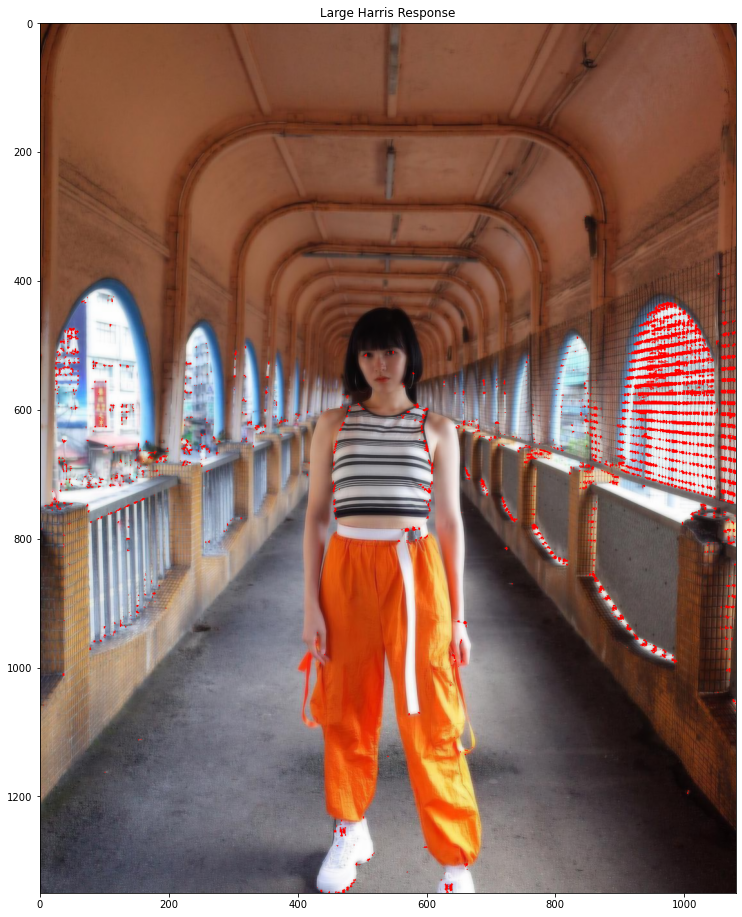

Done Harris...


In [14]:
# Calculate Harris response and the max of Harris response
harris_response, hmax = structure_tensor(img, img_mix)

## Step 4. Non-Maximal Suppression
Since there are usually a lot of candidates for detected corners, see image `Large Harris Response`, we apply non-maximal suppression technique to find the most promising candidate among given sliding window.
As the name implies, we only keep the max Harris response within a given window size and set other candidates in the window to `0` to suppress their signals.

In [15]:
def nms(img_gray, harris_response, hmax, window_size=3):
    '''
    To do non maximum suppression to input image.

    img_gray: Original image in gray scale.
    harris_response: Harris response from structure_tensor().
    hmax: The maximum value in harris_response from structure_tensor().
    window_size: Window size to do NMS. Default to 3.
    '''

    # Get image size
    y = img_gray.shape[0]
    x = img_gray.shape[1]

    # Greate 3 channels for gray image
    img = np.array([[[s, s, s] for s in pixel] for pixel in img_gray])

    # Set up threshold
    threshold = 0.01*hmax

    for i in range(y):
        # Define local box height
        box_y = i+window_size
        if(box_y > y):
            box_y = y

        for j in range(x):

            # Filter those non candidate
            if (harris_response[i][j] < threshold):
                continue

            else:
                # Define local box width
                box_x = j+window_size
                if(box_x > x):
                    box_x = x

                # Scanning box
                box = harris_response[i:box_y, j:box_x]
                # print(box)

                # Find the max index
                box_max_idx = np.argmax(box)

                # Find the max coordinate
                target = np.unravel_index(box_max_idx, box.shape)

                # Find the max value
                box_max = box[target[0]][target[1]]

                # Non max suppression
                harris_response[i:box_y, j:box_x] = 0
                harris_response[i+target[0]][j+target[1]] = box_max

                # print(harris_response[i:box_y, j:box_x])

    img[harris_response > threshold] = [0, 0, 255]

    # Display the result
    imageshow(img, cmap='bgr', savefile=False,
              filename='Non-Maximal Suppression (window size '+ str(window_size) +')')

    print("Finish!")

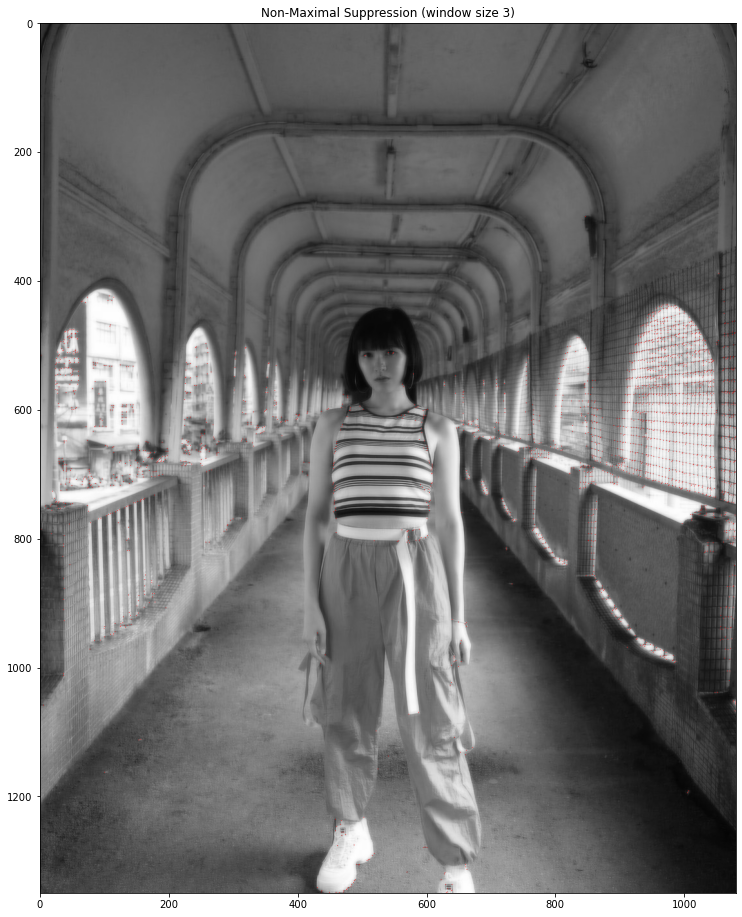

Finish!


In [16]:
# Do non maximum suppression
# (Result image in grayscale)
nms(img_gray, harris_response, hmax, window_size=3)
# (Result image in color)
# nms(img, harris_response, hmax, window_size=30)

## References
1. Slides from NTHU Computer Vision lecture (CS6550).